In [1]:
!gpustat

blade.seas.upenn.edu  Mon Aug  9 13:54:50 2021  455.45.01
[0] RTX A6000        | 83'C,  99 % | 44884 / 48685 MB | wangh19(44881M)
[1] RTX A6000        | 30'C,   0 % |     1 / 48685 MB |
[2] RTX A6000        | 32'C,   0 % |     1 / 48685 MB |
[3] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[4] RTX A6000        | 32'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 84'C, 100 % | 44696 / 48685 MB | shyamss(44693M)
[7] RTX A6000        | 32'C,   0 % |     1 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from jax import numpy as np
from jax import grad, vmap, random
import numpy as onp
from matplotlib import pyplot as plt

In [4]:
path = 'dynamical_system/bp_'

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [6]:
sigma = np.linspace(0,4,100)
X = np.array(onp.random.randn(4096, 100)).T

In [7]:
rhs = lambda sigma, X: np.sqrt(((1 - np.tanh(X * sigma) ** 2)**2).mean())
Y = vmap(rhs)(sigma, X)

In [8]:
rhs_grad = vmap(grad(rhs))(sigma, X)

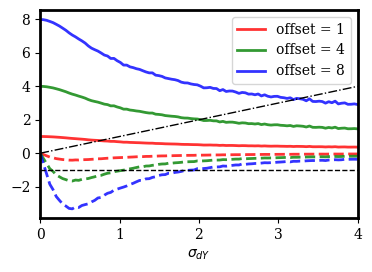

In [47]:
plt.figure(figsize = (4,3))
for offset, c in zip([1., 4., 8.], ['r', 'g', 'b']):
    plt.plot(sigma, offset * Y, color = c, label = f'offset = {int(offset)}', alpha = 0.8)
    plt.plot(sigma, offset * rhs_grad, linestyle = '--', color = c, alpha = 0.8)
plt.plot(sigma, sigma, 'k-.', linewidth = 1)
plt.axhline(-1, color = 'k', linestyle = '--', linewidth = 1)
plt.xlabel(r'$\sigma_{dY}$')
# plt.ylabel(r'$\sigma_{dX}$')
plt.xlim([0, 4])
plt.legend(bbox_to_anchor = [1., 1.])
plt.tight_layout()
plt.savefig(path + f'rhs_multi_offset.pdf', dpi = 200)
plt.show()
plt.close()

In [42]:
def rhs_fn(x, offset, S = sigma, Y = Y):
    return np.interp(x, S, offset * Y)

def find_root(fun, max_it = 200, minval = 0.01, maxval = 4, eps = 1e-2):
    
    
    for i in range(max_it):
        midval = (maxval + minval) / 2
        
        max_f = fun(maxval)
        min_f = fun(minval)
        mid_f = fun(midval)
        
        if mid_f * max_f < 0:
            minval = midval
        else:
            maxval = midval

        
        if np.abs((maxval - minval)) < eps:
#             print('Maximum iteration not reached')
            break
    return midval

def rhs_root(offset, **kwag):
    fun = lambda x: rhs_fn(x, offset) - x
    return find_root(fun, **kwag)

def rhs_grad_fn(x, offset, S = sigma, Y_grad = rhs_grad):
    return np.interp(x, S, offset * Y_grad)
    

In [44]:
offsets = np.linspace(0.01, 10, 50)

rhs_roots = []
rhs_root_grads = []
for offset in offsets:
    root = rhs_root(offset)
    rhs_roots.append(root)
    rhs_root_grads.append(rhs_grad_fn(root, offset))
    

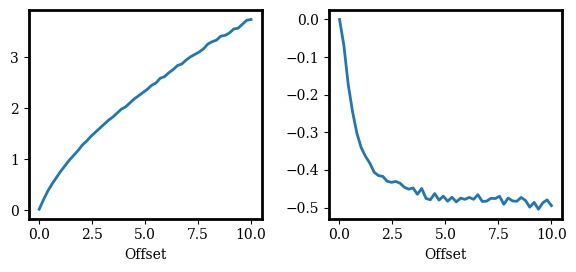

In [51]:
plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plt.plot(offsets, rhs_roots)
plt.xlabel(r'Offset')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(offsets, rhs_root_grads)
plt.xlabel(r'Offset')
plt.tight_layout()

plt.savefig(path + f'rhs_roots_and_grad.pdf', dpi = 200)

plt.show()
plt.close()